In [4]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [5]:
matches=pd.read_csv('matches.csv')

home_matches=matches.groupby( ['tournament_id', 'home_team_name'] ).agg({'match_id': 'count'}).reset_index() 
home_matches = home_matches.rename( columns={ 'match_id': 'home_matches_number', 'home_team_name': 'team_name' } )

away_matches=matches.groupby( ['tournament_id', 'away_team_name'] ).agg({'match_id': 'count'}).reset_index() 
away_matches = away_matches.rename( columns={ 'match_id': 'away_matches_number', 'away_team_name': 'team_name' } )

match_number = home_matches.merge( away_matches, on=['tournament_id', 'team_name'], how='outer' )
match_number.loc[ match_number['home_matches_number'].isna(), 'home_matches_number' ] = 0
match_number.loc[ match_number['away_matches_number'].isna(), 'away_matches_number' ] = 0

match_number['total_match_number'] = match_number['home_matches_number'] + match_number['away_matches_number']

#match_number.head() 

In [6]:
tournament_data= pd.read_csv('tournaments.csv')
bookings_data= pd.read_csv('bookings.csv')
pd.set_option('display.max_columns', None)
bookings_data.head()

,key_id,booking_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,minute_label,minute_regulation,minute_stoppage,match_period,yellow_card,red_card,second_yellow_card,sending_off
0,1,B-0001,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-69,Soviet Union,SUN,0,1,P-07448,Asatiani,Kakhi,11,30',30,0,first half,1,0,0,0
1,2,B-0002,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-69,Soviet Union,SUN,0,1,P-07350,Nodia,Givi,19,31',31,0,first half,1,0,0,0
2,3,B-0003,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-69,Soviet Union,SUN,0,1,P-00603,Lovchev,Evgeny,6,34',34,0,first half,1,0,0,0
3,4,B-0004,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-09033,Peña,Gustavo,3,60',60,0,second half,1,0,0,0
4,5,B-0005,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-69,Soviet Union,SUN,0,1,P-04868,Logofet,Gennady,7,72',72,0,second half,1,0,0,0


In [7]:
tournament_data = tournament_data.rename( columns={'winner': 'team_name'} )
#display of dataframe
#tournament_data.head() 

In [8]:
bookings_data=bookings_data[['booking_id', 'match_id', 'yellow_card', 'red_card', 'team_name', 'tournament_id' ]]
#bookings_data

In [9]:
winner_booking_info= tournament_data.merge( bookings_data, on=['tournament_id', 'team_name'], how='inner' )
winner_booking_info = winner_booking_info.sort_values('tournament_id')
#winner_booking_info.head() 

In [10]:
winner_booking_info=winner_booking_info.groupby(['tournament_id', 'team_name']).agg( {'yellow_card': 'sum', 'red_card': 'sum'} ).reset_index()
winner_booking_info=winner_booking_info.rename(columns={'team_name' : 'winner_teams'})

winner_booking_info['Time'] = winner_booking_info.index.values

winner_booking_info = winner_booking_info.merge( match_number, left_on=['tournament_id', 'winner_teams'], right_on=['tournament_id', 'team_name'], how='left' )

winner_booking_info['avg_yellow_card'] = winner_booking_info['yellow_card'] / winner_booking_info['total_match_number']
winner_booking_info['avg_red_card'] = winner_booking_info['red_card'] / winner_booking_info['total_match_number']

#non_winner_booking_info
#winner_booking_info

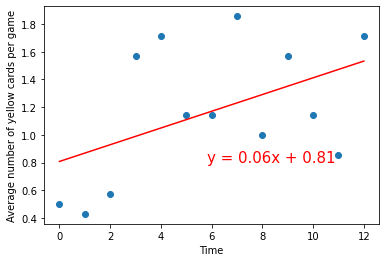

In [11]:
x_values = winner_booking_info['Time']
y_values = winner_booking_info['avg_yellow_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel("Time")
plt.ylabel('Average number of yellow cards per game')
plt.show()

In [12]:
non_winner_booking_info = bookings_data.merge( tournament_data[ [ 'tournament_id', 'team_name' ] ], \
                      how='outer', left_on=['tournament_id', 'team_name'], \
                      right_on=['tournament_id', 'team_name'], indicator=True )

non_winner_booking_info = non_winner_booking_info.loc[ non_winner_booking_info['_merge'] == 'left_only' ]

#non_winner_booking_info.head()

In [13]:
#checking if anti-merge worked
non_winner_booking_info.loc[ non_winner_booking_info['tournament_id'] == 'WC-1974', 'team_name' ].unique()

array(['Yugoslavia', 'Chile', 'East Germany', 'Zaire', 'Scotland',
       'Uruguay', 'Haiti', 'Argentina', 'Brazil', 'Bulgaria', 'Sweden',
       'Netherlands', 'Italy', 'Australia', 'Poland'], dtype=object)

In [14]:
non_winner_booking_info=non_winner_booking_info.groupby(['tournament_id', 'team_name']).agg( {'yellow_card': 'sum', 'red_card': 'sum'} ).reset_index()
non_winner_booking_info=non_winner_booking_info.rename(columns={'team_name' : 'non_winner_teams'})

#non_winner_booking_info

In [15]:
match_number.loc[ match_number['home_matches_number'].isna(), : ]

,tournament_id,team_name,home_matches_number,away_matches_number,total_match_number


In [16]:
match_number.isna().any() 

tournament_id          False
team_name              False
home_matches_number    False
away_matches_number    False
total_match_number     False
dtype: bool

In [17]:
non_winner_booking_info = non_winner_booking_info.merge( match_number, left_on=['tournament_id', 'non_winner_teams'], right_on=['tournament_id', 'team_name'], how='left' )

non_winner_booking_info

,tournament_id,non_winner_teams,yellow_card,red_card,team_name,home_matches_number,away_matches_number,total_match_number
0,WC-1970,Belgium,3.0,0.0,Belgium,1.0,2.0,3.0
1,WC-1970,Czechoslovakia,2.0,0.0,Czechoslovakia,0.0,3.0,3.0
2,WC-1970,El Salvador,4.0,0.0,El Salvador,0.0,3.0,3.0
3,WC-1970,England,2.0,0.0,England,2.0,2.0,4.0
4,WC-1970,Israel,4.0,0.0,Israel,0.0,3.0,3.0
...,...,...,...,...,...,...,...,...
312,WC-2018,Spain,2.0,0.0,Spain,2.0,2.0,4.0
313,WC-2018,Sweden,8.0,0.0,Sweden,3.0,2.0,5.0
314,WC-2018,Switzerland,9.0,1.0,Switzerland,1.0,3.0,4.0
315,WC-2018,Tunisia,4.0,0.0,Tunisia,1.0,2.0,3.0


In [18]:
non_winner_booking_info['avg_yellow_card'] = non_winner_booking_info['yellow_card'] / non_winner_booking_info['total_match_number']
non_winner_booking_info['avg_red_card'] = non_winner_booking_info['red_card'] / non_winner_booking_info['total_match_number']

non_winner_booking_info

,tournament_id,non_winner_teams,yellow_card,red_card,team_name,home_matches_number,away_matches_number,total_match_number,avg_yellow_card,avg_red_card
0,WC-1970,Belgium,3.0,0.0,Belgium,1.0,2.0,3.0,1.000000,0.00
1,WC-1970,Czechoslovakia,2.0,0.0,Czechoslovakia,0.0,3.0,3.0,0.666667,0.00
2,WC-1970,El Salvador,4.0,0.0,El Salvador,0.0,3.0,3.0,1.333333,0.00
3,WC-1970,England,2.0,0.0,England,2.0,2.0,4.0,0.500000,0.00
4,WC-1970,Israel,4.0,0.0,Israel,0.0,3.0,3.0,1.333333,0.00
...,...,...,...,...,...,...,...,...,...,...
312,WC-2018,Spain,2.0,0.0,Spain,2.0,2.0,4.0,0.500000,0.00
313,WC-2018,Sweden,8.0,0.0,Sweden,3.0,2.0,5.0,1.600000,0.00
314,WC-2018,Switzerland,9.0,1.0,Switzerland,1.0,3.0,4.0,2.250000,0.25
315,WC-2018,Tunisia,4.0,0.0,Tunisia,1.0,2.0,3.0,1.333333,0.00


In [19]:
#need to group non_winner booking info by tournament so that there are the same number of rows as winning booking info table (0-12)
non_winner_booking_tourn_info = non_winner_booking_info.groupby(['tournament_id']).agg( {'avg_yellow_card': 'mean', 'avg_red_card': 'mean'} ).reset_index()
non_winner_booking_tourn_info

,tournament_id,avg_yellow_card,avg_red_card
0,WC-1970,1.020833,0.000000
1,WC-1974,1.157143,0.098413
2,WC-1978,0.625850,0.057823
3,WC-1982,0.913420,0.057576
4,WC-1986,1.426948,0.042100
5,WC-1990,1.715217,0.095031
6,WC-1994,2.348861,0.065010
7,WC-1998,1.995699,0.140630
8,WC-2002,2.193088,0.080952
9,WC-2006,2.829954,0.049770


In [20]:
non_winner_booking_tourn_info['Time'] = non_winner_booking_tourn_info.index.values
non_winner_booking_tourn_info

,tournament_id,avg_yellow_card,avg_red_card,Time
0,WC-1970,1.020833,0.000000,0
1,WC-1974,1.157143,0.098413,1
2,WC-1978,0.625850,0.057823,2
3,WC-1982,0.913420,0.057576,3
4,WC-1986,1.426948,0.042100,4
5,WC-1990,1.715217,0.095031,5
6,WC-1994,2.348861,0.065010,6
7,WC-1998,1.995699,0.140630,7
8,WC-2002,2.193088,0.080952,8
9,WC-2006,2.829954,0.049770,9


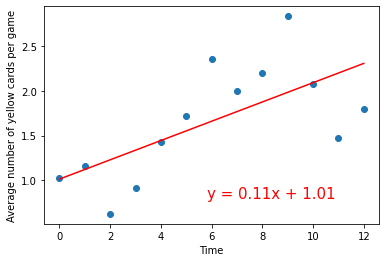

In [21]:
x_values = non_winner_booking_tourn_info['Time']
y_values = non_winner_booking_tourn_info['avg_yellow_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel("Time")
plt.ylabel('Average number of yellow cards per game')
plt.show()

In [27]:
#boxplot code for winner_booking_info

#we need a list of the tournament_id's for the x axis and then the count of card will be the y Axis
tournaments = winner_booking_info["tournament_id"].values
winner_yellow_card_count= winner_booking_info["avg_yellow_card"].values
winner_red_card_count= winner_booking_info["avg_red_card"].values

tournaments = winner_booking_info["tournament_id"].values
nonwinner_yellow_card_count= non_winner_booking_tourn_info["avg_yellow_card"].values
nonwinner_red_card_count= non_winner_booking_tourn_info["avg_red_card"].values



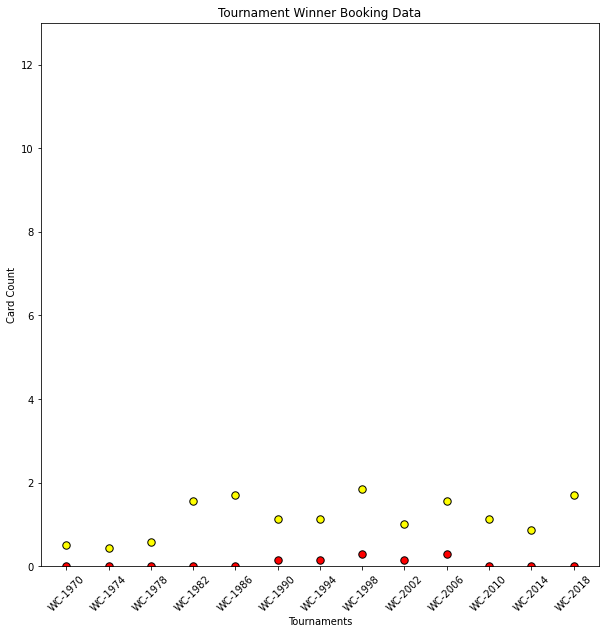

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(tournaments, winner_yellow_card_count ,s =55, facecolors="yellow", edgecolors="black")
plt.scatter(tournaments, winner_red_card_count ,s =55, facecolors="red", edgecolors="black")
plt.xlabel("Tournaments")
plt.xticks(rotation=45)
plt.ylabel("Card Count")
plt.ylim(0,13)
plt.title("Tournament Winner Booking Data")
plt.show()

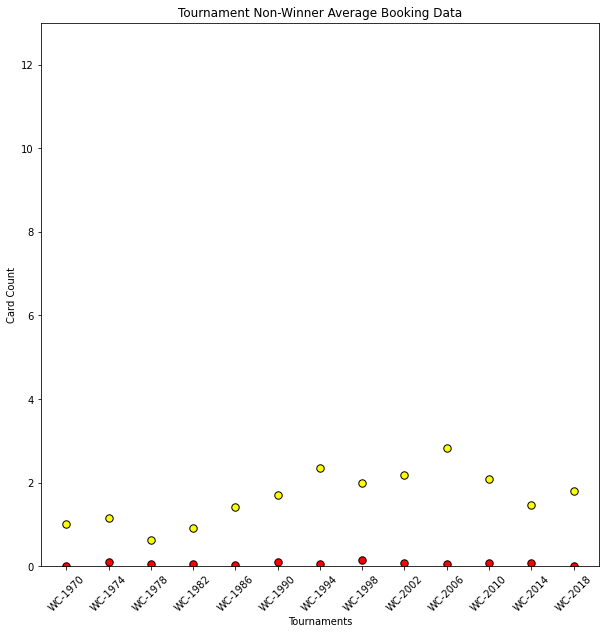

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(tournaments, nonwinner_yellow_card_count ,s =55, facecolors="yellow", edgecolors="black")
plt.scatter(tournaments, nonwinner_red_card_count ,s =55, facecolors="red", edgecolors="black")
plt.xlabel("Tournaments")
plt.xticks(rotation=45)
plt.ylabel("Card Count")
plt.ylim(0,13)
plt.title("Tournament Non-Winner Average Booking Data")
plt.show()

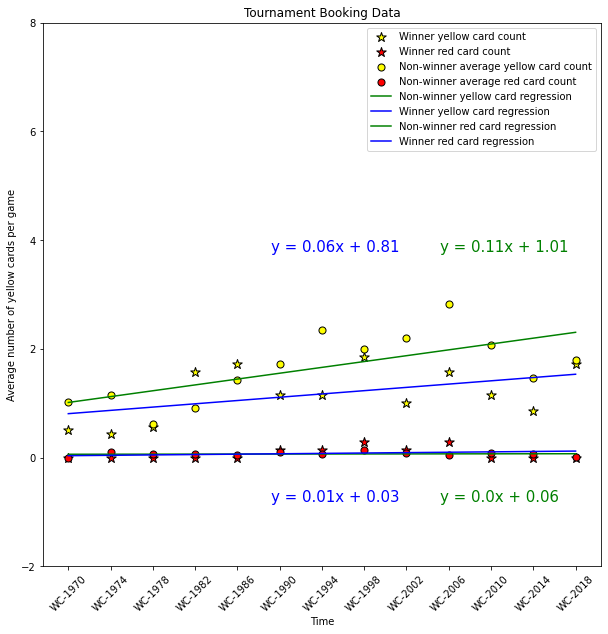

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(tournaments, winner_yellow_card_count , marker= '*',s =100, facecolors="yellow", edgecolors="black", label = "Winner Yellow Card")
plt.scatter(tournaments, winner_red_card_count ,marker= '*',s =100, facecolors="red", edgecolors="black", label = "Winner Red Card")
plt.scatter(tournaments, nonwinner_yellow_card_count ,s =50, facecolors="yellow", edgecolors="black", label = "NonWinner Average Yellow Card")
plt.scatter(tournaments, nonwinner_red_card_count ,s =50, facecolors="red", edgecolors="black", label = "NonWinner Average Red Card")
plt.ylim(-2,8)
plt.xlabel("Tournaments")
plt.xticks(rotation=45)
plt.ylabel("Card Count")
plt.title("Tournament Booking Data")
plt.legend(loc='best')

x_values = non_winner_booking_tourn_info['Time']
y_values = non_winner_booking_tourn_info['avg_yellow_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"g-")
plt.annotate(line_eq,(8.8,3.8),fontsize=15,color="green")
plt.xlabel("Time")
plt.ylabel('Average number of yellow cards per game')

x_values = winner_booking_info['Time']
y_values = winner_booking_info['avg_yellow_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(4.8,3.8),fontsize=15,color="blue")
plt.xlabel("Time")
plt.ylabel('Average number of yellow cards per game')

################

x_values = non_winner_booking_tourn_info['Time']
y_values = non_winner_booking_tourn_info['avg_red_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"g-")
plt.annotate(line_eq,(8.8,-0.8),fontsize=15,color="green")
#plt.xlabel("Time")
#plt.ylabel('Average number of yellow cards')

#################

x_values = winner_booking_info['Time']
y_values = winner_booking_info['avg_red_card']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress( x_values, y_values )
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plt.scatter(x_values,y_values)

plt.plot(x_values,regress_values,"b-")
plt.annotate(line_eq,(4.8,-0.8),fontsize=15,color="blue")

plt.legend( ( 'Winner yellow card count', 'Winner red card count', 'Non-winner average yellow card count', 'Non-winner average red card count', 'Non-winner yellow card regression','Winner yellow card regression' , 'Non-winner red card regression', 'Winner red card regression' ) )

plt.show()


In [31]:
from scipy import stats
stats.ttest_ind(winner_booking_info['avg_yellow_card'].values,non_winner_booking_tourn_info['avg_yellow_card'].values)

Ttest_indResult(statistic=-2.201810470879714, pvalue=0.03753321465563549)

In [32]:
stats.ttest_ind(winner_booking_info['avg_red_card'].values,non_winner_booking_tourn_info['avg_red_card'].values)

Ttest_indResult(statistic=0.3438111009101068, pvalue=0.7339823053221999)